# Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2  # Import cv2
from sklearn.metrics import classification_report, confusion_matrix
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm



# check each library

In [2]:
try:
    # Torch and CUDA check
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)

    # Numpy check
    array = np.array([1, 2, 3])
    print("Numpy works! Array:", array)

    # JSON check
    data = {"key": "value"}
    json_str = json.dumps(data)
    print("JSON works! String:", json_str)

    # OS check
    current_dir = os.getcwd()
    print("OS works! Current directory:", current_dir)

    # OpenCV check
    image = np.zeros((100, 100, 3), dtype=np.uint8)
    cv2.putText(image, "Test", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    print("OpenCV works! Image shape:", image.shape)

    print("All libraries are installed and working correctly!")

except Exception as e:
    print(f"Error occurred: {e}")

Torch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
Numpy works! Array: [1 2 3]
JSON works! String: {"key": "value"}
OS works! Current directory: c:\Users\engab\Desktop\stuff\uni\1\UTS\Autunm- 2025\42174 Artificial Intelligence Studio\FVLegion_InitialDev-main\training
OpenCV works! Image shape: (100, 100, 3)
All libraries are installed and working correctly!


# # --- 1. Data Preprocessing ---

In [3]:
class PoseDataset(Dataset):
    def __init__(self, data_dir, action_classes, max_frames=40):
        self.data_dir = data_dir
        self.action_classes = action_classes
        self.max_frames = max_frames  # Maximum number of frames per clip
        self.data, self.labels = self.load_data()


    def load_data(self):
        data = []
        labels = []
        for i, action in enumerate(self.action_classes):
            action_dir = os.path.join(self.data_dir, action)
            if not os.path.exists(action_dir):
              print(f"Warning: Directory not found: {action_dir}")  # Debugging
              continue

            for filename in os.listdir(action_dir):
                if filename.endswith("_keypoints.json"):
                    filepath = os.path.join(action_dir, filename)
                    try:
                        with open(filepath, 'r') as f:
                            keypoints_data = json.load(f)
                            # Extract keypoints and normalize

                            normalized_keypoints = self.process_keypoints(keypoints_data)
                            if normalized_keypoints is not None:
                                data.append(normalized_keypoints)
                                labels.append(i)  # Use index as label
                    except (json.JSONDecodeError, FileNotFoundError) as e:
                        print(f"Error loading or processing {filepath}: {e}")
                        continue  # Skip to the next file

        return data, labels

    def process_keypoints(self, keypoints_data):
        all_frames_keypoints = []
        previous_frame = None  # For temporal smoothing
        alpha = 0.8  # Smoothing factor for EMA

        for frame_data in keypoints_data:
            if not isinstance(frame_data, dict) or 'keypoints' not in frame_data:
                print(f"Skipping invalid frame data: {frame_data}")  # Debugging
                continue  # Skip malformed data

            frame_keypoints = frame_data['keypoints']
            if not isinstance(frame_keypoints, list) or len(frame_keypoints) == 0:
                print("frame keypoints is not a list or is empty")
                continue

            frame_keypoints_np = np.array(frame_keypoints[0]).reshape(-1, 3)  # First person, (17, 3)
            if frame_keypoints_np.shape != (17, 3):
                print(f"Incorrect shape: {frame_keypoints_np.shape}")
                continue

            # Filter out keypoints with low confidence
            valid_keypoints = frame_keypoints_np[frame_keypoints_np[:, 2] > 0.2]
            if valid_keypoints.size == 0:
                continue

            # Z-Score Normalization
            mean_x = np.mean(valid_keypoints[:, 0])
            std_x = np.std(valid_keypoints[:, 0]) + 1e-8  # Avoid division by zero
            mean_y = np.mean(valid_keypoints[:, 1])
            std_y = np.std(valid_keypoints[:, 1]) + 1e-8

            normalized_frame_keypoints = frame_keypoints_np.copy()
            normalized_frame_keypoints[:, 0] = (normalized_frame_keypoints[:, 0] - mean_x) / std_x
            normalized_frame_keypoints[:, 1] = (normalized_frame_keypoints[:, 1] - mean_y) / std_y

            # Temporal Smoothing using EMA
            if previous_frame is not None:
                normalized_frame_keypoints[:, 0] = alpha * normalized_frame_keypoints[:, 0] + (1 - alpha) * previous_frame[:, 0]
                normalized_frame_keypoints[:, 1] = alpha * normalized_frame_keypoints[:, 1] + (1 - alpha) * previous_frame[:, 1]

            previous_frame = normalized_frame_keypoints  # Update for the next iteration

            # Flatten and remove confidence scores
            normalized_frame_keypoints = normalized_frame_keypoints[:, :2].flatten()
            all_frames_keypoints.append(normalized_frame_keypoints)

        # Padding (or truncating)
        if not all_frames_keypoints:
            return None
        padded_keypoints = np.zeros((self.max_frames, all_frames_keypoints[0].shape[0]))
        for i, frame_kps in enumerate(all_frames_keypoints):
            if i < self.max_frames:
                padded_keypoints[i, :] = frame_kps

        return padded_keypoints


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# --- 2. Model Definition ---


In [4]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(hidden_size * 2, 1)  # hidden_size * 2 for BiLSTM

    def forward(self, lstm_output):
        # lstm_output: (batch_size, seq_length, hidden_size * 2)
        scores = self.attention_weights(lstm_output)  # (batch_size, seq_length, 1)
        attention_weights = torch.softmax(scores, dim=1)  # Softmax over the sequence length
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)  # Weighted sum of the outputs
        return context_vector, attention_weights.squeeze(-1)


class ActionRecognitionBiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(ActionRecognitionBiLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate, bidirectional=self.bidirectional)
        self.attention = AttentionLayer(hidden_size)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # (batch_size, seq_length, hidden_size * 2)
        out = self.dropout(out)

        context_vector, attention_weights = self.attention(out)

        # Decode the context vector from the attention layer
        out = self.fc(context_vector)
        return out, attention_weights


# --- 3. Training and Evaluation Setup ---


In [5]:
action_classes = ["Falling", "No Action", "Waving"]


# Hyperparameters
input_size = 34  # 17 keypoints * 2 (x, y)
hidden_size = 32
num_layers = 3
num_classes = len(action_classes)
learning_rate = 0.01
batch_size = 32
num_epochs = 30  # Increased epochs
dropout_rate = 0.2 # Dropout


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- 4. Data Loading ---


In [6]:
dataset = PoseDataset("../data collection v4/data", action_classes)

# Split the dataset
train_data, test_data, train_labels, test_labels = train_test_split(
    dataset.data, dataset.labels, test_size=0.2, random_state=42
)

# Create new datasets using the split data
train_dataset = PoseDataset("../data collection v4/data", action_classes)  # Pass action_classes
train_dataset.data = train_data
train_dataset.labels = train_labels
test_dataset = PoseDataset("../data collection v4/data", action_classes)   # and here
test_dataset.data = test_data
test_dataset.labels = test_labels

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize individual models separately
models = {
    "BiLSTMWithAttention": ActionRecognitionBiLSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device),
}


print(f"Using Ensemble Model: {[model.__class__.__name__ for model in models]}")
logging.info(f"Using Ensemble Model: {[model.__class__.__name__ for model in models]}")



Using Ensemble Model: ['str']


# --- 5. Training and Evaluation Loop ---


In [7]:
# Get the current working directory
current_dir = os.getcwd()
log_file = os.path.join(current_dir, 'BiLSTM_training_updated_attention_BILSTM_4.0.log')

# Reconfigure logging to avoid being ignored if already configured
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging
logging.basicConfig(
    filename=log_file,  # Use the full path for the log file
    level=logging.INFO,  # Log level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    datefmt='%Y-%m-%d %H:%M:%S'  # Date format
)

print(f" THE CURRENT DIR IS 🔫🔫{current_dir}")
logging.info("Logging initialized successfully.")

 THE CURRENT DIR IS 🔫🔫c:\Users\engab\Desktop\stuff\uni\1\UTS\Autunm- 2025\42174 Artificial Intelligence Studio\FVLegion_InitialDev-main\training


In [10]:
def visualize_average_saliency_per_class(model, data_loader, action_label, action_name, save_dir, epoch):
    os.makedirs(save_dir, exist_ok=True)

    # Prepare
    model.train()  # Ensure model is in train mode for backward()
    
    keypoint_positions = {
        0: (0, 10), 1: (0, 8), 2: (-1, 6), 3: (-2, 4), 4: (-2, 2),
        5: (1, 6), 6: (2, 4), 7: (2, 2), 8: (-1, 4), 9: (-1, 2),
        10: (-1, 0), 11: (1, 4), 12: (1, 2), 13: (1, 0),
        14: (-0.3, 11), 15: (0.3, 11), 16: (-0.5, 10.5),
    }
    skeleton_connections = [
        (0,1), (1,2), (2,3), (3,4), (1,5), (5,6), (6,7),
        (1,8), (8,9), (9,10), (1,11), (11,12), (12,13),
        (0,14), (0,15), (14,16)
    ]
    keypoint_labels = [
        "Nose","Neck","R.Shoulder","R.Elbow","R.Wrist","L.Shoulder","L.Elbow","L.Wrist",
        "R.Hip","R.Knee","R.Ankle","L.Hip","L.Knee","L.Ankle","R.Eye","L.Eye","R.Ear"
    ]

    saliency_accumulator, count = [], 0

    for keypoints, labels in data_loader:
        keypoints, labels = keypoints.to(device), labels.to(device)
        indices = (labels == action_label).nonzero(as_tuple=True)[0]
        
        for idx in indices:
            keypoints_sample = keypoints[idx:idx+1].clone().detach().requires_grad_(True)
            outputs = model(keypoints_sample)
            logits, _ = outputs if isinstance(outputs, tuple) else (outputs, None)
            pred_class = logits.argmax(1).item()
            model.zero_grad()
            score = logits[0, pred_class]
            score.backward()

            grads = keypoints_sample.grad[0].view(keypoints_sample.size(1), 17, 2).abs().mean(dim=2)
            avg_grads = grads.mean(dim=0).cpu().numpy()
            saliency_accumulator.append(avg_grads)
            count += 1

    if count == 0:
        print(f"No samples found for action {action_name}.")
        model.eval()  # Switch back to eval
        return

    avg_saliency = np.mean(saliency_accumulator, axis=0)
    norm_scores = (avg_saliency - avg_saliency.min()) / (avg_saliency.ptp() + 1e-8)

    # Plot
    plt.figure(figsize=(6,10))
    colormap = cm.get_cmap('coolwarm')
    for p1, p2 in skeleton_connections:
        plt.plot([keypoint_positions[p1][0], keypoint_positions[p2][0]],
                 [keypoint_positions[p1][1], keypoint_positions[p2][1]],
                 'gray', linewidth=1, alpha=0.7)
    for idx in range(17):
        x, y = keypoint_positions[idx]
        plt.scatter(x, y, s=norm_scores[idx]*800+150, c=[colormap(norm_scores[idx])], edgecolors='k', linewidths=1, zorder=3)
        plt.text(x+0.1, y+0.1, f"{idx}:{keypoint_labels[idx]}", fontsize=9, color='black', zorder=4)
    plt.title(f"Avg Saliency for {action_name} (Epoch {epoch+1})\nCircle size/color: Keypoint importance")
    plt.axis('off'); plt.xlim(-3,3); plt.ylim(-1,12); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"saliency_{action_name}_epoch_{epoch+1}.png"), bbox_inches='tight')
    plt.close()

    model.eval()  # Switch back to eval

criterion = nn.CrossEntropyLoss()
metrics = {}

for model_name, model in models.items():
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_accuracy = 0.0
    best_model_path = f"{model_name}_best_model_4.0.pth"

    print(f"Training model: {model_name}")
    logging.info(f"Training model: {model_name}")
    metrics[model_name] = {"train_losses": [], "test_losses": [], "accuracies": []}

    for epoch in range(num_epochs):
        # ----- Training -----
        model.train()
        train_loss = 0.0
        for keypoints, labels in train_loader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            outputs = model(keypoints)
            if isinstance(outputs, tuple): outputs = outputs[0]
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * keypoints.size(0)
        train_loss /= len(train_dataset)
        metrics[model_name]["train_losses"].append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - {model_name}, Train Loss: {train_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        scheduler.step(train_loss)

        # ----- Evaluation -----
        model.eval()
        correct, total, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for keypoints, labels in test_loader:
                keypoints, labels = keypoints.to(device), labels.to(device)
                outputs = model(keypoints)
                if isinstance(outputs, tuple): outputs = outputs[0]
                loss = criterion(outputs, labels)
                test_loss += loss.item() * keypoints.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss /= len(test_dataset)
        accuracy = 100 * correct / total
        metrics[model_name]["test_losses"].append(test_loss)
        metrics[model_name]["accuracies"].append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] - {model_name}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # ----- Attention Visualization -----
        class_attentions = {cls: [] for cls in range(num_classes)}
        model.eval()  # Ensure eval for attention
        with torch.no_grad():
            for keypoints, labels in test_loader:
                keypoints = keypoints.to(device)
                outputs = model(keypoints)
                if isinstance(outputs, tuple):
                    _, attn = outputs
                    for i, label in enumerate(labels.cpu().numpy()):
                        class_attentions[label].append(attn[i].cpu().numpy())
        os.makedirs("attention_outputs", exist_ok=True)
        fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))
        for cls in range(num_classes):
            if class_attentions[cls]:
                avg_attn = np.mean(class_attentions[cls], axis=0)
                ax = axes[cls] if num_classes > 1 else axes
                sns.heatmap([avg_attn], ax=ax, cmap='viridis', cbar=True)
                ax.set_title(action_classes[cls])
                ax.set_xticks([]), ax.set_yticks([])
        plt.tight_layout()
        plt.savefig(f"attention_outputs/attention_epoch_{epoch+1}.png")
        plt.close()

        # ----- Saliency Visualization -----
        action_dirs = {0: "saliency_falling_outputs", 1: "saliency_no_action_outputs", 2: "saliency_waving_outputs"}
        action_names = {0: "Falling", 1: "No Action", 2: "Waving"}

        for action_label, action_name in action_names.items():
            model.train()  # CuDNN backward needs train mode
            visualize_average_saliency_per_class(
                model=model,
                data_loader=test_loader,
                action_label=action_label,
                action_name=action_name,
                save_dir=action_dirs[action_label],
                epoch=epoch
            )
            model.eval()  # Optional: reset to eval

        # ----- Save Best Model -----
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved: {best_model_path} with accuracy: {best_accuracy:.2f}%")

    print(f"Training complete for {model_name}. Best accuracy: {best_accuracy:.2f}%")
    logging.info(f"Training complete for {model_name}. Best accuracy: {best_accuracy:.2f}%")

Training model: BiLSTMWithAttention
Epoch [1/30] - BiLSTMWithAttention, Train Loss: 0.4407, LR: 0.010000
Epoch [1/30] - BiLSTMWithAttention, Test Loss: 0.2371, Accuracy: 93.10%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Best model saved: BiLSTMWithAttention_best_model_4.0.pth with accuracy: 93.10%
Epoch [2/30] - BiLSTMWithAttention, Train Loss: 0.2761, LR: 0.010000
Epoch [2/30] - BiLSTMWithAttention, Test Loss: 0.4679, Accuracy: 83.91%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [3/30] - BiLSTMWithAttention, Train Loss: 0.2088, LR: 0.010000
Epoch [3/30] - BiLSTMWithAttention, Test Loss: 0.3091, Accuracy: 91.95%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [4/30] - BiLSTMWithAttention, Train Loss: 0.3195, LR: 0.010000
Epoch [4/30] - BiLSTMWithAttention, Test Loss: 0.1891, Accuracy: 93.10%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [5/30] - BiLSTMWithAttention, Train Loss: 0.1717, LR: 0.010000
Epoch [5/30] - BiLSTMWithAttention, Test Loss: 0.2177, Accuracy: 93.10%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [6/30] - BiLSTMWithAttention, Train Loss: 0.1383, LR: 0.010000
Epoch [6/30] - BiLSTMWithAttention, Test Loss: 0.2083, Accuracy: 94.25%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Best model saved: BiLSTMWithAttention_best_model_4.0.pth with accuracy: 94.25%
Epoch [7/30] - BiLSTMWithAttention, Train Loss: 0.1351, LR: 0.010000
Epoch [7/30] - BiLSTMWithAttention, Test Loss: 0.2853, Accuracy: 93.10%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [8/30] - BiLSTMWithAttention, Train Loss: 0.0529, LR: 0.010000
Epoch [8/30] - BiLSTMWithAttention, Test Loss: 0.3159, Accuracy: 94.25%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [9/30] - BiLSTMWithAttention, Train Loss: 0.1431, LR: 0.010000
Epoch [9/30] - BiLSTMWithAttention, Test Loss: 0.3143, Accuracy: 91.95%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [10/30] - BiLSTMWithAttention, Train Loss: 0.2494, LR: 0.010000
Epoch [10/30] - BiLSTMWithAttention, Test Loss: 0.3214, Accuracy: 91.95%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [11/30] - BiLSTMWithAttention, Train Loss: 0.0938, LR: 0.010000
Epoch [11/30] - BiLSTMWithAttention, Test Loss: 0.2139, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Best model saved: BiLSTMWithAttention_best_model_4.0.pth with accuracy: 95.40%
Epoch [12/30] - BiLSTMWithAttention, Train Loss: 0.0921, LR: 0.010000
Epoch [12/30] - BiLSTMWithAttention, Test Loss: 0.2894, Accuracy: 93.10%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [13/30] - BiLSTMWithAttention, Train Loss: 0.1612, LR: 0.010000
Epoch [13/30] - BiLSTMWithAttention, Test Loss: 0.3184, Accuracy: 94.25%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [14/30] - BiLSTMWithAttention, Train Loss: 0.0894, LR: 0.010000
Epoch [14/30] - BiLSTMWithAttention, Test Loss: 0.2878, Accuracy: 90.80%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [15/30] - BiLSTMWithAttention, Train Loss: 0.0487, LR: 0.005000
Epoch [15/30] - BiLSTMWithAttention, Test Loss: 0.2613, Accuracy: 93.10%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [16/30] - BiLSTMWithAttention, Train Loss: 0.0554, LR: 0.005000
Epoch [16/30] - BiLSTMWithAttention, Test Loss: 0.2745, Accuracy: 94.25%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [17/30] - BiLSTMWithAttention, Train Loss: 0.0210, LR: 0.005000
Epoch [17/30] - BiLSTMWithAttention, Test Loss: 0.2816, Accuracy: 94.25%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [18/30] - BiLSTMWithAttention, Train Loss: 0.0119, LR: 0.005000
Epoch [18/30] - BiLSTMWithAttention, Test Loss: 0.2873, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [19/30] - BiLSTMWithAttention, Train Loss: 0.0070, LR: 0.005000
Epoch [19/30] - BiLSTMWithAttention, Test Loss: 0.2778, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [20/30] - BiLSTMWithAttention, Train Loss: 0.0044, LR: 0.005000
Epoch [20/30] - BiLSTMWithAttention, Test Loss: 0.2841, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [21/30] - BiLSTMWithAttention, Train Loss: 0.0030, LR: 0.005000
Epoch [21/30] - BiLSTMWithAttention, Test Loss: 0.3031, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [22/30] - BiLSTMWithAttention, Train Loss: 0.0019, LR: 0.005000
Epoch [22/30] - BiLSTMWithAttention, Test Loss: 0.3291, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [23/30] - BiLSTMWithAttention, Train Loss: 0.0016, LR: 0.005000
Epoch [23/30] - BiLSTMWithAttention, Test Loss: 0.3422, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [24/30] - BiLSTMWithAttention, Train Loss: 0.0013, LR: 0.005000
Epoch [24/30] - BiLSTMWithAttention, Test Loss: 0.3477, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [25/30] - BiLSTMWithAttention, Train Loss: 0.0010, LR: 0.005000
Epoch [25/30] - BiLSTMWithAttention, Test Loss: 0.3526, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [26/30] - BiLSTMWithAttention, Train Loss: 0.0009, LR: 0.005000
Epoch [26/30] - BiLSTMWithAttention, Test Loss: 0.3565, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [27/30] - BiLSTMWithAttention, Train Loss: 0.0007, LR: 0.005000
Epoch [27/30] - BiLSTMWithAttention, Test Loss: 0.3599, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [28/30] - BiLSTMWithAttention, Train Loss: 0.0006, LR: 0.005000
Epoch [28/30] - BiLSTMWithAttention, Test Loss: 0.3640, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [29/30] - BiLSTMWithAttention, Train Loss: 0.0006, LR: 0.005000
Epoch [29/30] - BiLSTMWithAttention, Test Loss: 0.3674, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Epoch [30/30] - BiLSTMWithAttention, Train Loss: 0.0005, LR: 0.005000
Epoch [30/30] - BiLSTMWithAttention, Test Loss: 0.3711, Accuracy: 95.40%


C:\Users\engab\AppData\Local\Temp\ipykernel_23128\591907189.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


Training complete for BiLSTMWithAttention. Best accuracy: 95.40%


# 6. testing all models and generating classifications report with confusion metrics on the whole dataset in the folders ---


## 6.1. Testing Block for BiLSTMWithAttention Model


Classification Report for BiLSTMWithAttention:
              precision    recall  f1-score   support

     Falling       0.98      1.00      0.99       139
   No Action       0.98      0.96      0.97       125
      Waving       0.98      0.98      0.98        84

    accuracy                           0.98       348
   macro avg       0.98      0.98      0.98       348
weighted avg       0.98      0.98      0.98       348

Confusion Matrix for BiLSTMWithAttention:


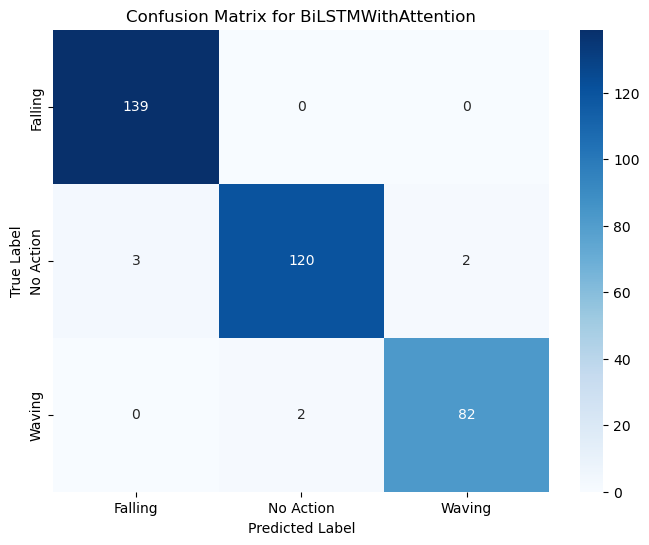

In [11]:
# Load the model
model_name = "BiLSTMWithAttention"
model = ActionRecognitionBiLSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
model.load_state_dict(torch.load(f"{model_name}_best_model_4.0.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for keypoints, labels in train_loader:
        keypoints = keypoints.to(device)
        labels = labels.to(device)

        outputs = model(keypoints)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Handle attention-based models

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Classification Report for {model_name}:")
print(classification_report(all_labels, all_preds, target_names=action_classes))

print(f"Confusion Matrix for {model_name}:")
conf_matrix = confusion_matrix(all_labels, all_preds)
action_classes = ["Falling", "No Action", "Waving"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=action_classes, yticklabels=action_classes)
plt.title(f"Confusion Matrix for {model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Accuracy: 95.40%

Classification Report:
              precision    recall  f1-score   support

     Falling       1.00      0.95      0.97        41
   No Action       0.87      0.95      0.91        21
      Waving       0.96      0.96      0.96        25

    accuracy                           0.95        87
   macro avg       0.94      0.95      0.95        87
weighted avg       0.96      0.95      0.95        87


Confusion Matrix:
[[39  2  0]
 [ 0 20  1]
 [ 0  1 24]]


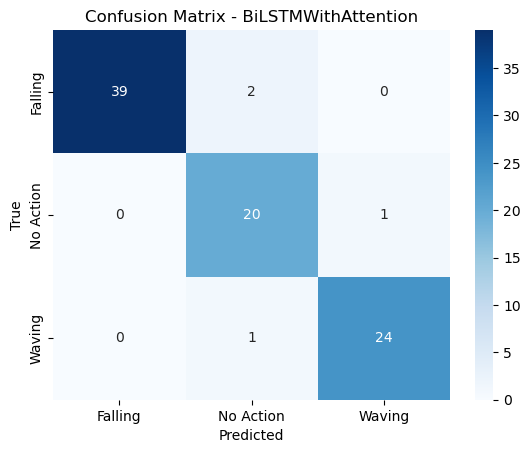

In [12]:
 # Load the model
model_path = "BiLSTMWithAttention_best_model_4.0.pth"
model_name = "BiLSTMWithAttention"
model = ActionRecognitionBiLSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
correct = 0
total = 0
all_labels = []
all_predictions = []
# Load the model weights
model.load_state_dict(torch.load(model_path))
model.eval()  # Set to evaluation mode

# Disable gradient computation for evaluation
with torch.no_grad():
    for keypoints, labels in test_loader:
        keypoints = keypoints.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(keypoints)

        # Handle tuple output (e.g., attention-based models)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store labels and predictions for further analysis
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=action_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=action_classes, yticklabels=action_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {model_name}")
plt.show()

In [13]:
print(model)

ActionRecognitionBiLSTMWithAttention(
  (lstm): LSTM(34, 32, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): AttentionLayer(
    (attention_weights): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


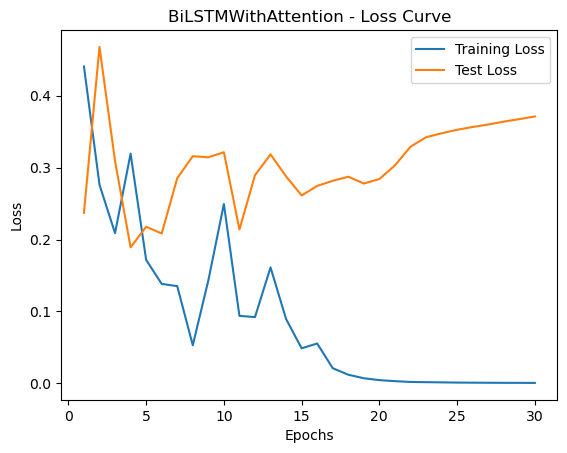

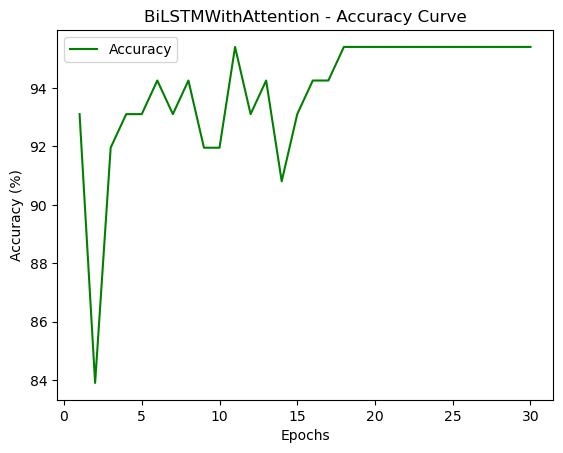

In [14]:
model_name = "BiLSTMWithAttention"
train_losses = metrics[model_name]["train_losses"]
test_losses = metrics[model_name]["test_losses"]
accuracies = metrics[model_name]["accuracies"]

# Plot training and test loss
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"{model_name} - Loss Curve")
plt.legend()
plt.show()

# Plot accuracy
plt.plot(range(1, num_epochs + 1), accuracies, label="Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title(f"{model_name} - Accuracy Curve")
plt.legend()
plt.show()